<a href="https://colab.research.google.com/github/sundarjhu/UACJ_EngineeringWeek2021/blob/main/SIMBAD_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
__author__ = 'Sundar Srinivasan <s.srinivasan@irya.unam.mx>'
__version__ = '20210921'
__datasets__ = ['SIMBAD']  # datos usados en este notebook
__keywords__ = ['Engineering Week', 'UACJ', '2021', 'SIMBAD', 'ADQL'], # palabras clave relevantes a este notebook

# **Accessing data from SIMBAD, demonstrating ADQL basics**
---



---



In [ ]:
from astropy.table import Table, join
import numpy as np
!pip install pyvo
import pyvo as vo

## Create a table of source identifiers, save to VOTable. This will serve as input for our queries.

In [ ]:
id = ['lam Vel', 'IRAS 16205-2626', 'eta Car', 'alp Cen', 'IRC +10216'] #unique identifiers for three stars
hemisphere = ['Southern', 'Southern', 'Southern', 'Southern', 'Northern'] #which celestial hemisphere?
input_tab = Table([id, hemisphere], names = ('ID', 'hemisphere'))
input_tab.pprint()
input_tab.write('input_tab.vot', format = 'votable', overwrite = True)

### Automatically obtain the url for the SIMBAD TAP server by doing a regsearch using PyVO

In [ ]:
r = vo.regsearch(servicetype = 'tap', keywords = ['Simbad'])
SIMBAD_service = r[0].service

In [ ]:
# This is the url to the TAP server
SIMBAD_service.baseurl

### SIMBAD contains many tables: https://simbad.u-strasbg.fr/simbad/tap/tapsearch.html

#### The `basic` table has some basic information for each source.

In [ ]:
#Select all columns from the first row of basic data
query = """ SELECT top 1 * FROM basic """ # change "1" to any number to view that many rows in the output
results = SIMBAD_service.search(query).to_table() #submit the ADQL query to the SIMBAD TAP server, and convert the response into an astropy table
results.colnames
#You can use this to inspect the column names and their content in the table

In [ ]:
#How many rows are there in this table?
query = """ select count(coo_bibcode) as NUMROWS from basic"""
results = SIMBAD_service.search(query).to_table() #submit the ADQL query to the SIMBAD TAP server, and convert the response into an astropy table
results

In [ ]:
#HEY, waitaminit! I asked for the column to be in all caps, why isn't it?
#Because ADQL is case-insensitive unless you enclose the argument in quotes
query = """ select count(coo_bibcode) as "NUMROWS" from basic"""
results = SIMBAD_service.search(query).to_table() #submit the ADQL query to the SIMBAD TAP server, and convert the response into an astropy table
results

In [ ]:
#SUBSETS with WHERE: How many rows are there in this table with DEC < 0?
query = """ select count(coo_bibcode) as NUMROWS from basic WHERE dec < 0"""
results = SIMBAD_service.search(query).to_table() #submit the ADQL query to the SIMBAD TAP server, and convert the response into an astropy table
results

query = """ select top 100 coo_bibcode as NUMROWS from basic WHERE dec < 0"""
results = SIMBAD_service.search(query).to_table() #submit the ADQL query to the SIMBAD TAP server, and convert the response into an astropy table
results


# There are three important tables in SIMBAD: `basic`, `ident`, and `ids`. 

>> # `basic` contains the basic information for each source (positions, velocities, photometry, redshift, etc.). If a source is known by many names, there is an entry for EACH such name recognized by SIMBAD.

>> # Each source in these tables is identified by a unique identifier, a long integer called *oid* (in `basic`) and *oidref* (in `ident`, `ids`). You can connect a source to its various names using these two columns.

>> # You can obtain a list of references for the sources in the same way using the tables `ref` and `has_ref`.

In [ ]:
# Get some information from the basic table for the object with name 'CW Leo', which is NOT its standard SIMBAD name.
#
query = """
-- Basic data from an object given one of its identifiers.
-- Notice how you can comment ADQL queries!
SELECT basic.OID,
       RA,
       DEC,
       main_id AS "Main identifier",
       coo_bibcode AS "Coord Reference",
       nbref AS "NbReferences",
       plx_value as "Parallax",
       rvz_radvel as "Radial velocity",
       galdim_majaxis,
       galdim_minaxis,
       galdim_angle AS "Galaxy ellipse angle"
FROM basic JOIN ident ON oidref = oid
WHERE id = 'CW Leo'
"""
results = SIMBAD_service.search(query).to_table()
results

### Get all the identifiers for one source

In [ ]:
query = """select t0.main_id, t1.id, t2.ids from basic as t0, ident as t1, ids as t2 where t0.oid = t1.oidref and t1.id = 'CW Leo' and t1.oidref = t2.oidref"""
results = SIMBAD_service.search(query).to_table()
results

# How to upload a table!
### Get all the identifiers for a list of sources 

In [ ]:
input_tab

In [ ]:
query = """select mytable.id, t2.ids from mytable, ident as t1, ids as t2 where t1.id = mytable.ID and t1.oidref = t2.oidref"""
results = SIMBAD_service.search(query, uploads = {'mytable': 'input_tab.vot'}).to_table()
results

# Simple cone search
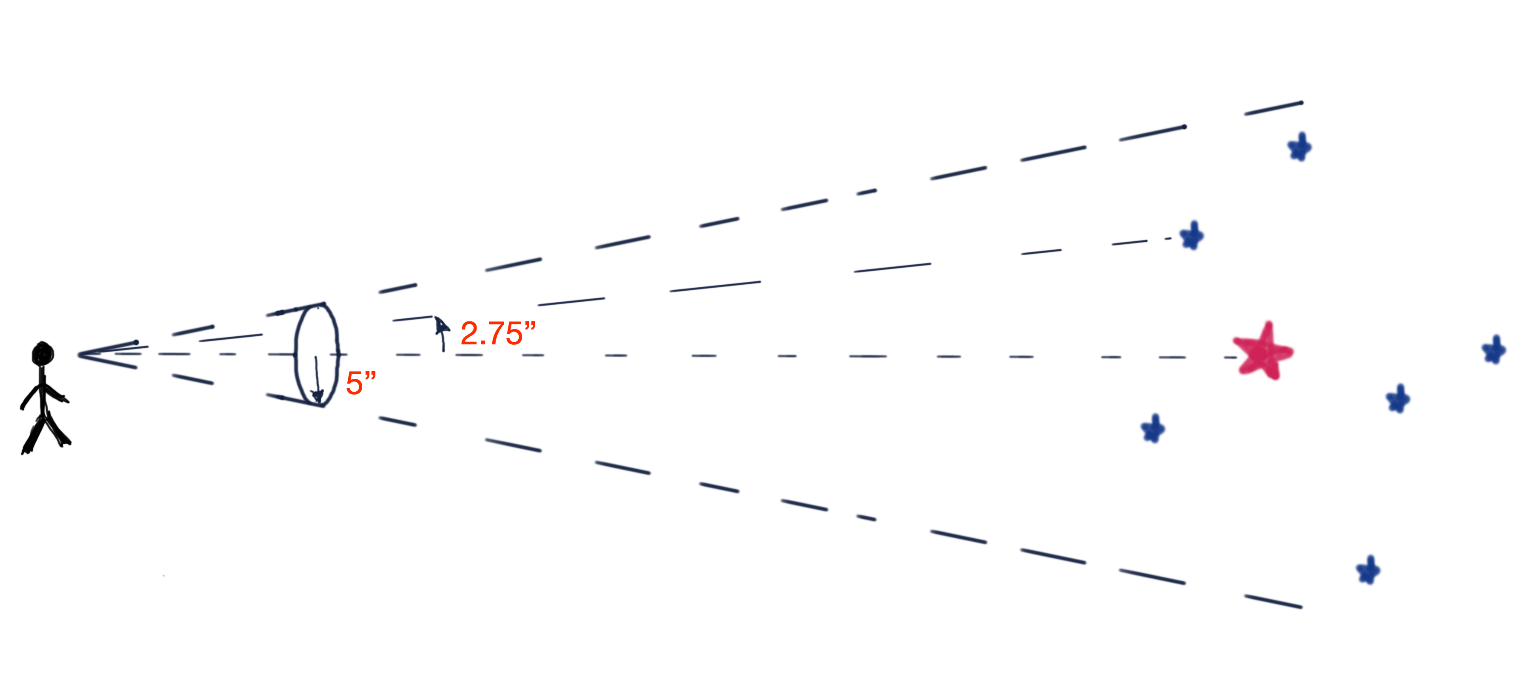
>## In this example, we select the location RA = 10 deg, DEC = 5 deg, and search for SIMBAD matches within a 1 deg radius of it.
>## We arrange the results in ascending order of angular distance using the DISTANCE function.

In [ ]:
query = """
-- Display basic data about objects contained in a given circle and whose mag B < 9.0.
SELECT basic.OID,
       RA,
       DEC,
       DISTANCE(POINT('ICRS', RA, DEC), POINT('ICRS', 10, 5)) * 60 as dist_arcmin,
       main_id AS "Main identifier",
       coo_bibcode AS "BiblioReference",
       nbref AS "NbReferences",
       plx_value as "Parallax",
       rvz_radvel as "Radial velocity",
       galdim_majaxis,
       galdim_minaxis,
       galdim_angle AS "Galaxy ellipse angle"
FROM basic JOIN flux ON oidref = oid
WHERE filter = 'B'
      AND flux < 9.0
      AND CONTAINS(POINT('ICRS', RA, DEC), CIRCLE('ICRS', 10, 5, 1)) = 1
ORDER BY dist_arcmin
"""
results = SIMBAD_service.search(query).to_table()
results

# Cone search for list of sources in an input table
>## In this example, we select the locations (RA, DEC) specified for a list of sources in an input table and search for SIMBAD matches within a 2 arcmin radius of each position.
>## For each source in the input table, the matches are arranged in ascending order of angular separation using the DISTANCE function. The ORDER BY clause is used to first arrange the results in order of the unique identifier, then (for each unique identifer) by increasing match distance.

In [ ]:
id = [1000001, 1000012, 1005016, 1052200] #some unique long-integer identifier
RA = [74.2, 159.4, 55.5, 355.959]
DEC = [44.6, -13.39, 62.7, 3.209]
input_table = Table([id, RA, DEC], names = ('ID', 'RA', 'DEC'))
input_table.write('input_tab.vot', format = 'votable', overwrite = True)

#Notice how the match radius is no longer hard-coded. We can change the radius outside
#   of the query string as follows. The query string changes in an automated fashion.
#   This is useful if we need to change the match radius outside the code block
#   that contains the query. It can then be fed as an argument to the query block.
match_radius = '2.0 / 60' #the match radius is set to 2 arc minutes.

query = """
SELECT a.ID, a.RA, a.DEC, main_id as "Main identifier", 
  b.RA AS matched_RA, b.DEC AS matched_DEC, coo_bibcode AS "Coord_BibRef",
  DISTANCE(POINT('ICRS', b.RA, b.DEC), POINT('ICRS', a.RA, a.DEC)) * 60 AS dist_arcmin,
  nbref AS "NbReferences", plx_value AS "Parallax",
  rvz_radvel AS "Radial velocity"
FROM mytable a LEFT JOIN basic b
ON CONTAINS(POINT('ICRS', b.RA, b.DEC), CIRCLE('ICRS', a.RA, a.DEC, """ + match_radius + """)) = 1
ORDER BY ID, dist_arcmin
"""

results = SIMBAD_service.search(query, uploads = {'mytable': 'input_tab.vot'}).to_table()
results

# Cone search for list of sources using a virtual input table
>## This example uses the same data as the previous one; the only difference is that it avoids writing to (or reading from) a file, and doesn't require an actual file to be passed as input to the query. Instead, we use a byte stream through the BytesIO method.

In [ ]:
id = [1000001, 1000012, 1005016, 1052200] #some unique long-integer identifier
RA = [74.2, 159.4, 55.5, 355.959]
DEC = [44.6, -13.39, 62.7, 3.209]
input_table = Table([id, RA, DEC], names = ('ID', 'RA', 'DEC'))

#This is the only part of the code above that changes
from io import BytesIO
from astropy.io import votable
votable_object = BytesIO()
votable.writeto(votable.from_table(input_table), votable_object)
votable_object.seek(0)
#The rest of the code remains the same, except that we feed as input
# to the query not the VOTable file, but the VOTable object.

match_radius = str(2.0 / 60) #the match radius is set to 2 arc minutes.

query = """
SELECT a.ID, a.RA, a.DEC, main_id as "Main identifier", 
  b.RA AS matched_RA, b.DEC AS matched_DEC, coo_bibcode AS "Coord_BibRef",
  DISTANCE(POINT('ICRS', b.RA, b.DEC), POINT('ICRS', a.RA, a.DEC)) * 60 AS dist_arcmin,
  nbref AS "NbReferences", plx_value AS "Parallax",
  rvz_radvel AS "Radial velocity"
FROM mytable a LEFT JOIN basic b
ON CONTAINS(POINT('ICRS', b.RA, b.DEC), CIRCLE('ICRS', a.RA, a.DEC, """ + match_radius + """)) = 1
ORDER BY ID, dist_arcmin
"""

#The following line has changed
results = SIMBAD_service.search(query, uploads = {'mytable': votable_object}).to_table()
results

>## The above method is useful when we're dealing with large tables and/or we want to manipulate the table columns before feeding it to the search, without affecting the original table.

In [ ]:
id = [1000001, 1000012, 1005016, 1052200] #some unique long-integer identifier
RA = [74.2, 159.4, 55.5, 355.959]
DEC = [44.6, -13.39, 62.7, 3.209]

#Some extra columns that make the table somewhat larger than before
Facility = ['Butter Glider', 'Magic Murder Bag', 'Vacuum Boom-Broom', 'The Revenge Society']
Saturated = [True, True, False, True]
ObsDate = ['2016', '2015', '1999', '2016']
Observer = ['Fitzcarraldo, Malcolm', 'Killinger, Henry', 'Venture, Thaddeus S.', 'Fântomas, Hamilton G.']
input_table = Table([id, RA, DEC, Facility, Saturated, ObsDate, Observer], \
                    names = ('ID', 'RA', 'DEC', 'Facility', 'Saturated', 'ObsDate', 'Observer'))

from io import BytesIO
from astropy.io import votable
votable_object = BytesIO()
#This line has changed. Note how only the necessary columns are being written to the VOTable object.
votable.writeto(votable.from_table(input_table['ID', 'RA', 'DEC']), votable_object)
votable_object.seek(0)

match_radius = str(5.0 / 60) #the match radius is set to 5 arc minutes.

query = """
SELECT a.ID, a.RA, a.DEC, main_id as "Main identifier", b.oid,
  b.RA AS matched_RA, b.DEC AS matched_DEC, coo_bibcode AS "Coord_BibRef",
  DISTANCE(POINT('ICRS', b.RA, b.DEC), POINT('ICRS', a.RA, a.DEC)) * 60 AS dist_arcmin,
  nbref AS "NbReferences", plx_value AS "Parallax",
  rvz_radvel AS "Radial velocity"
FROM mytable a LEFT JOIN basic b
ON CONTAINS(POINT('ICRS', b.RA, b.DEC), CIRCLE('ICRS', a.RA, a.DEC, """ + match_radius + """)) = 1
ORDER BY ID, dist_arcmin ASC
"""

results = SIMBAD_service.search(query, uploads = {'mytable': votable_object}).to_table()

#If needed, we can now add back the columns we ignored in the input table
"""IMPORTANT NOTE: the query results table MUST be the first argument to the join command in order to retain the ordering of distance.
  You can verify that this order isn't always preserved if input_table is used as the first argument by changing the line below.
"""
output_table = join(results, input_table, keys = ['ID', 'RA', 'DEC'], join_type = 'left')
output_table

## Selecting only the nearest-neighbour match for each source in the above example
> ### Since we've already arranged the matches in ascending order of distance, and performed the join using the query results as the first argument, we simply select the first entry for each source. This can be implemented using `numpy`'s `unique` method.

In [ ]:
_, u = np.unique(output_table['ID'], return_index = True)
output_table[u]

# Obtaining a list of tables in the SIMBAD database with their descriptions
> ### A table named `tables` contains this information

In [ ]:
query = """SELECT * FROM tables"""
results = SIMBAD_service.search(query).to_table()
print("This table has {} rows.".format(len(results)))
results['table_name', 'description'].pprint_all()

# Accessing references and bibliography codes from SIMBAD
> ### The information about which publication studied which object is stored in two tables: `ref` and `has_Ref`.
> ### `ref` contains the bibliography information for the paper and a unique identifier, `oidbib`, for each publication.
> ### `has_Ref` connects the unique object identifiers, `oidref`, to the unique bibliography identifiers `oidbibref`.


---

## In the following, we will find publications that have studied the objects in `output_table`.


In [ ]:
from io import BytesIO
from astropy.io import votable
votable_object = BytesIO()
# Note how only the necessary columns are being written to the VOTable object.
votable.writeto(votable.from_table(output_table['Main identifier', 'oid']), votable_object)
votable_object.seek(0)

query = """
            SELECT "Main identifier", oid, r.bibcode, r.doi, r.journal, r.page, r.volume, r."year", r.title
            FROM mytable a, has_Ref as hr, ref as r
            WHERE a.oid = hr.oidref and hr.oidbibref = r.oidbib
"""

output_table_refs = SIMBAD_service.search(query, uploads = {'mytable': votable_object}).to_table()

# Combine this with the full table of results obtained from the cone search
# The right join allows for the possibility that a given source may appear in multiple publications
final_table = join(output_table, output_table_refs, keys = ["Main identifier", "oid"], join_type = 'right')

# The url to the ADS entry for the publication can be generated from the `bibcode` column:
final_table['biburl'] = ['https://ui.adsabs.harvard.edu/abs/' + t['bibcode'] + '/abstract' for t in output_table_refs]

In [ ]:
final_table[:10].pprint_all()